# Detection of PCB Defects Using Deep Learning (YOLO Algorithm)
This notebook will make an end to end deep learning model to detect a defect in printed circuit board (PCB). More specifically, the notebook will make use of **YOLO v9 algorithm**.

## Downloading Kaggle Dataset
First, we will load dataset using Kaggle, as shown in below code snippet.

In [ ]:
%%time
import os, sys, shutil, tarfile
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'pcb-defects:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1364422%2F2266446%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240904%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240904T233721Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D811e1c5574f1c1b02965f94f9aca033bf964ab821f013ea8dd052b4c204ddf83a869b7f7061ef3365531bf73c0dab1a65a9949c84394e40c854b222f49d7bc6a701b183d2e0c55c4511564ede970787d246dffc8531dde99c603e2521665f6fe42f4b2ce506d010e05dda818489f109974fd37c0e04885068ef2dc97739fffc44e28441f696b721bf784ac990a050603fc9f42c76167d76a949bd24178ef160f94875431898c817f557b940bb484f49f9043fcef27559098246b8a84e4413068e144ba9163c8c8e27c5a8ad33ed7f4a0acc9e1bcb53223d567b8f4c5b8c5e362991654fccdc2e3e0c5f4c793653dc85ed909b0ed61d7390892b8477656668336'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null

shutil.rmtree('/kaggle/input',
              ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777,
            exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777,
            exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 2013426922 bytes downloaded
Downloaded and uncompressed: pcb-defects
Data source import complete.
CPU times: user 1min 24s, sys: 16.2 s, total: 1min 40s
Wall time: 2min 30s


In [ ]:
# installing reuqired package
%%time
!pip install -U ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.7/871.7 kB 47.1 MB/s eta 0:00:00
CPU times: user 42.2 ms, sys: 7.62 ms, total: 49.9 ms
Wall time: 5.03 s


## Importing Crucial Libraries
First, crucial packages will be imported, i.e., `pandas`, `cv2`, `ultratytics`, etc. Specifically, the `ultralytics` package is used to access YOLO model.

In [ ]:
import pandas as pd
import numpy as np
import cv2, os, shutil, random, yaml
import xml.etree.ElementTree as ET
from pathlib import Path
from collections import Counter
from ultralytics import *
from sklearn.model_selection import *
from matplotlib import pyplot as plt
import seaborn as sns

# Dataset Exploration
The dataset will be explored after libraries are imported successfully. This will include analysing images, annotations, etc.

In [ ]:
dataset_dir = os.path.join(KAGGLE_INPUT_PATH, 'pcb-defects/PCB_DATASET')

for root, dirs, files in os.walk(dataset_dir):
   for name in dirs:
      print(os.path.join(root, name))

/kaggle/input/pcb-defects/PCB_DATASET/rotation
/kaggle/input/pcb-defects/PCB_DATASET/images
/kaggle/input/pcb-defects/PCB_DATASET/PCB_USED
/kaggle/input/pcb-defects/PCB_DATASET/Annotations
/kaggle/input/pcb-defects/PCB_DATASET/rotation/Spur_rotation
/kaggle/input/pcb-defects/PCB_DATASET/rotation/Spurious_copper_rotation
/kaggle/input/pcb-defects/PCB_DATASET/rotation/Mouse_bite_rotation
/kaggle/input/pcb-defects/PCB_DATASET/rotation/Open_circuit_rotation
/kaggle/input/pcb-defects/PCB_DATASET/rotation/Missing_hole_rotation
/kaggle/input/pcb-defects/PCB_DATASET/rotation/Short_rotation
/kaggle/input/pcb-defects/PCB_DATASET/images/Spurious_copper
/kaggle/input/pcb-defects/PCB_DATASET/images/Short
/kaggle/input/pcb-defects/PCB_DATASET/images/Spur
/kaggle/input/pcb-defects/PCB_DATASET/images/Missing_hole
/kaggle/input/pcb-defects/PCB_DATASET/images/Open_circuit
/kaggle/input/pcb-defects/PCB_DATASET/images/Mouse_bite
/kaggle/input/pcb-defects/PCB_DATASET/Annotations/Spurious_copper
/kaggle/inp

### `count_files()` Function
The below function will count the number of files in a specified folder, along with their provided annotations.

In [ ]:
def count_files_in_folder(folder_path):
    # get list of all files in the folder
    files = os.listdir(folder_path)

    # count the number of files
    num_files = len(files)

    return num_files

### Applying `count_files_in_folder ()` Function

In [ ]:
subfolders = ['Missing_hole', 'Mouse_bite',
              'Open_circuit', 'Short',
              'Spur', 'Spurious_copper']

images_dir = os.path.joi  n(dataset_dir, 'images')
annot_dir = os.path.join(dataset_dir, 'Annotations')

for subfolder in subfolders:
    images_path = os.path.join(images_dir, subfolder)
    annot_path = os.path.join(annot_dir, subfolder)

    print(f'{subfolder:<15} \t\
            {count_files_in_folder(images_path)} images \t\
            {count_files_in_folder(annot_path)} annotations')

Missing_hole    	            115 images 	            115 annotations
Mouse_bite      	            115 images 	            115 annotations
Open_circuit    	            116 images 	            116 annotations
Short           	            116 images 	            116 annotations
Spur            	            115 images 	            115 annotations
Spurious_copper 	            116 images 	            116 annotations


## Data Preprocessing

In [ ]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    data = []

    filename = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)

    for obj in root.findall('object'):
        name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        data.append({
            'filename': filename,
            'width': width,
            'height': height,
            'class': name,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })

    return data

In [ ]:
# list to store parsed data from all XML files
all_data = []

# recursively traverse subdirectories
for root, dirs, files in os.walk(annot_dir):
    for name in files:
        if name.endswith('.xml'):
            xml_path = os.path.join(root, name)
            all_data.extend(parse_xml(xml_path))

In [ ]:
# create DataFrame from the parsed data
annot_df = pd.DataFrame(all_data)
annot_df.head(8)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,07_spurious_copper_10.jpg,2904,1921,spurious_copper,1049,243,1146,294
1,07_spurious_copper_10.jpg,2904,1921,spurious_copper,1634,662,1718,705
2,07_spurious_copper_10.jpg,2904,1921,spurious_copper,1863,774,1922,889
3,07_spurious_copper_10.jpg,2904,1921,spurious_copper,1515,874,1570,967
4,07_spurious_copper_10.jpg,2904,1921,spurious_copper,989,1098,1087,1148
5,06_spurious_copper_09.jpg,2868,2316,spurious_copper,1172,429,1289,469
6,06_spurious_copper_09.jpg,2868,2316,spurious_copper,1497,1515,1591,1555
7,06_spurious_copper_09.jpg,2868,2316,spurious_copper,1108,834,1181,872


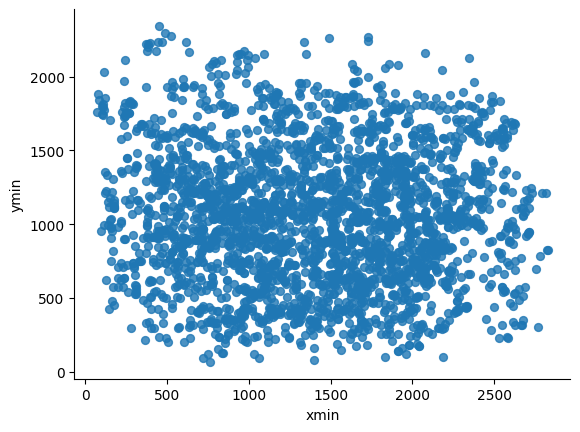

In [ ]:
annot_df.plot(kind='scatter',
              x='xmin',
              y='ymin',
              s=32,
              alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

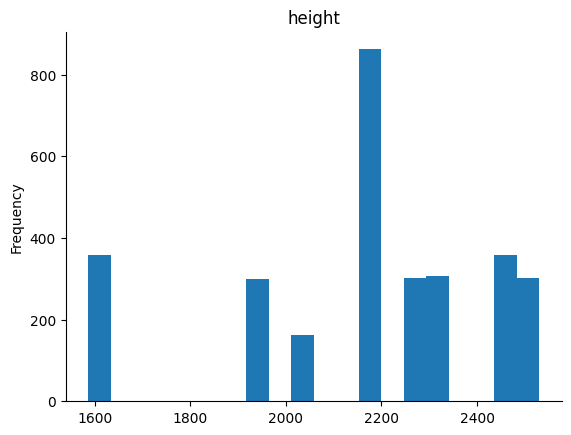

In [ ]:
annot_df['height'].plot(kind='hist',
                        bins=20,
                        title='height')
plt.gca().spines[['top', 'right',]].set_visible(False)

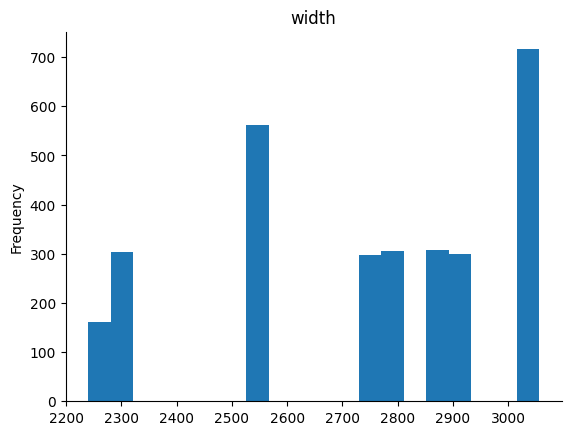

In [ ]:
annot_df['width'].plot(kind='hist', bins=20, title='width')
plt.gca().spines[['top', 'right',]].set_visible(False)

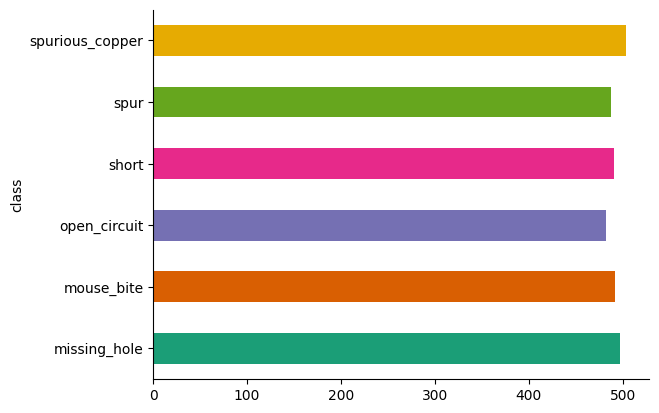

In [ ]:
annot_df.groupby('class').size().plot(kind='barh',
                                      color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## Dataset Visualization

In [ ]:
def get_subfolder(image_name):
    if 'missing' in image_name.split('_'):
        return 'Missing_hole'
    if 'mouse' in image_name.split('_'):
        return'Mouse_bite'
    if 'open' in image_name.split('_'):
        return 'Open_circuit'
    if 'short' in image_name.split('_'):
        return 'Short'
    if 'spur' in image_name.split('_'):
        return 'Spur'
    if 'spurious' in image_name.split('_'):
        return 'Spurious_copper'

### Visualizing Class Samples

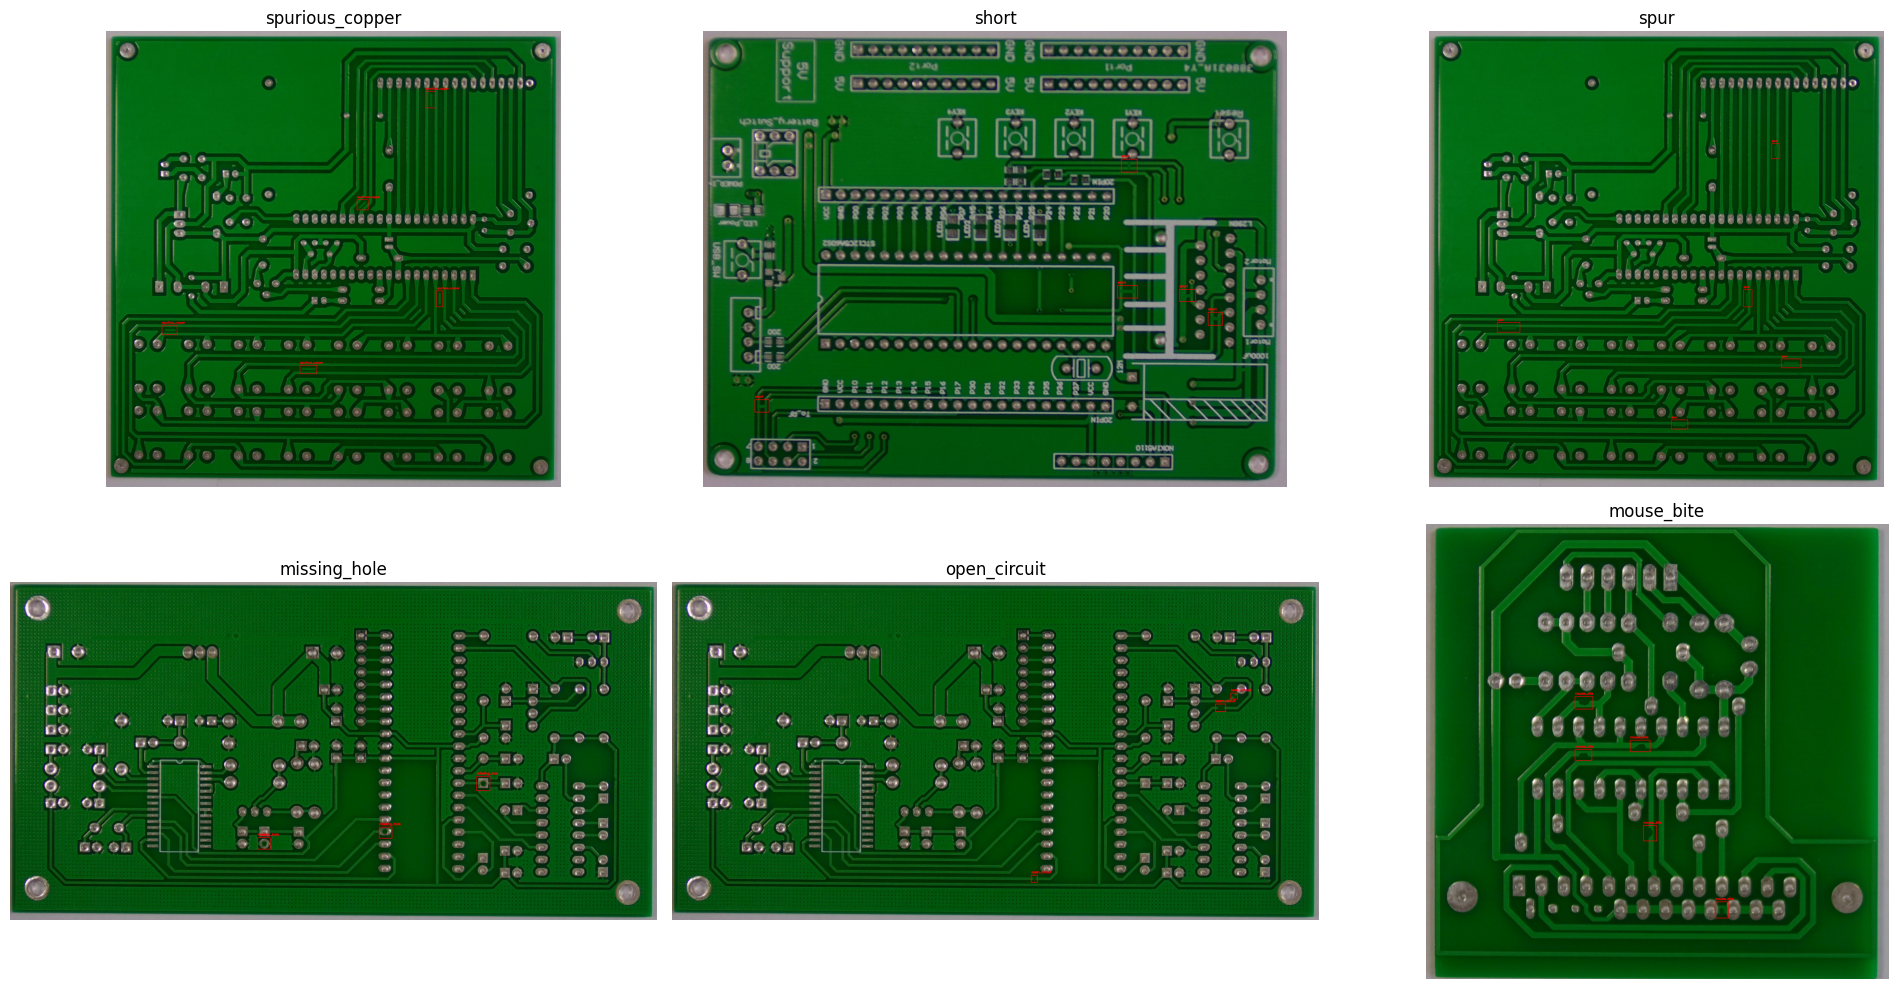

In [ ]:
classes = annot_df['class'].unique()

num_rows = 2
num_cols = len(classes) // num_rows + (len(classes) % num_rows > 0)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# flatten the axes array for easier iteration
axs = axs.flatten()

# iterate over classes and visualize annotations
for i, label in enumerate(classes):
  # filter the dataframe for the current class
  class_df = annot_df[annot_df['class'] == label]

  # select a random image from the class
  random_image = class_df.sample(1)['filename'].values[0]
  image_path = os.path.join(images_dir, get_subfolder(random_image), random_image)

  # visualize annotations
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # get bounding boxes and labels for the image
  image_df = class_df[class_df['filename'] == random_image]
  for index, row in image_df.iterrows():
    xmin = int(row['xmin'])
    ymin = int(row['ymin'])
    xmax = int(row['xmax'])
    ymax = int(row['ymax'])
    label = row['class']

    # draw bounding box
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

    # add label
    cv2.putText(img, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

  # display the image on the subplot
  axs[i].imshow(img)
  axs[i].set_title(label)
  axs[i].axis('off')

# adjust layout and display the plot
plt.tight_layout()
plt.show()

### `resize_images` Function

In [ ]:
def resize_images(input_dir, output_dir, target_size=(640, 640)):
    # create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # traverse through the subfolders in the input folder
    for root, _, files in os.walk(input_dir):
        for file in files:
            # Check if the file is an image
            if file.lower().endswith(('.jpg')):
                # read the image
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)

                # resize the image
                resized_image = cv2.resize(image, target_size)

                # save the resized image to the output folder
                output_path = os.path.join(output_dir, file)
                cv2.imwrite(output_path, resized_image)

# applying functions
resized_img_dir = os.path.join(dataset_dir, 'images_resized')
resize_images(images_dir, resized_img_dir)

### `resize_annotations()` Function

In [ ]:
def resize_annotations(annot_df, target_size=(640, 640)):
    all_data = []

    # iterate through the annotation DataFrame
    for index, row in annot_df.iterrows():

        # resize the bounding box coordinates
        width_ratio = target_size[0] / row['width']
        height_ratio = target_size[1] / row['height']

        resized_xmin = int(row['xmin'] * width_ratio)
        resized_ymin = int(row['ymin'] * height_ratio)
        resized_xmax = int(row['xmax'] * width_ratio)
        resized_ymax = int(row['ymax'] * height_ratio)

        # update the all data list with resized annotations
        all_data.append({
            'filename': row['filename'],
            'width': target_size[0],
            'height': target_size[1],
            'class': row['class'],
            'xmin': resized_xmin,
            'ymin': resized_ymin,
            'xmax': resized_xmax,
            'ymax': resized_ymax
        })

    annot_df_resized = pd.DataFrame(all_data)
    return annot_df_resized

annot_df_resized = resize_annotations(annot_df)
annot_df_resized.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,07_spurious_copper_10.jpg,640,640,spurious_copper,231,80,252,97
1,07_spurious_copper_10.jpg,640,640,spurious_copper,360,220,378,234
2,07_spurious_copper_10.jpg,640,640,spurious_copper,410,257,423,296
3,07_spurious_copper_10.jpg,640,640,spurious_copper,333,291,346,322
4,07_spurious_copper_10.jpg,640,640,spurious_copper,217,365,239,382


### Making YOLO Labels

In [ ]:
# Create the output directory
output_dir = os.path.join(dataset_dir,
                          'output')
os.makedirs(output_dir, exist_ok=True)

In [ ]:
X = Y = 640

def convert_to_yolo_labels(annotation_df, classes, target_size=(X, Y)):
    yolo_labels = []

    for _, annot in annotation_df.iterrows():
        filename = annot['filename']
        width, height = annot['width'], annot['height']
        class_name = annot['class']
        xmin, ymin, xmax, ymax = annot['xmin'], annot['ymin'], annot['xmax'], annot['ymax']

        # Convert bounding box coordinates to YOLO format
        x_center = (xmin + xmax) / (2 * width)
        y_center = (ymin + ymax) / (2 * height)
        bbox_width = (xmax - xmin) / width
        bbox_height = (ymax - ymin) / height

        class_index = classes.index(class_name)

        # Append to YOLO labels list
        yolo_labels.append((filename, class_index, x_center, y_center, bbox_width, bbox_height))

    return yolo_labels


classes = ['missing_hole', 'mouse_bite',
           'open_circuit',
           'short', 'spur',
           'spurious_copper']
yolo_labels = convert_to_yolo_labels(annot_df_resized, classes)

## Data Splicing

In [ ]:
def split_images_and_labels(images_dir, labels, output_dir,
                            train_split=0.95, val_split=0.05):
    os.makedirs(os.path.join(output_dir, 'images/train'),
                exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/val'),
                exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/test'),
                exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/train'),
                exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/val'),
                exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/test'),
                exist_ok=True)

    # group labels by image filename
    image_labels = {}
    for label in labels:
        filename, class_index, x_center, y_center, bbox_width, bbox_height = label
        if filename not in image_labels:
            image_labels[filename] = []
        image_labels[filename].append(label)

    # shuffle the image filenames
    image_filenames = list(image_labels.keys())
    random.shuffle(image_filenames)

    # split the dataset
    num_images = len(image_filenames)
    num_train = int(num_images * train_split)
    num_val = int(num_images * val_split)

    train_filenames = image_filenames[:num_train]
    val_filenames = image_filenames[num_train:num_train + num_val]
    test_filenames = image_filenames[num_train + num_val:]

    # write train, val, test images and labels
    for dataset, filenames in [('train', train_filenames), ('val', val_filenames), ('test', test_filenames)]:
        for filename in filenames:
            labels = image_labels[filename]
            with open(os.path.join(output_dir, f'labels/{dataset}/{os.path.splitext(filename)[0]}.txt'), 'a') as label_file:
                for label in labels:
                    _, class_index, x_center, y_center, bbox_width, bbox_height = label
                    label_file.write(f"{class_index} {x_center} {y_center} {bbox_width} {bbox_height}\n")
            # Copy images to corresponding folders
            shutil.copy(os.path.join(images_dir, filename), os.path.join(output_dir, f'images/{dataset}/{filename}'))

# applying function
split_images_and_labels(resized_img_dir,
                        yolo_labels,
                        output_dir)

In [ ]:
dataset_path = Path(output_dir)
labels = sorted(dataset_path.rglob("*labels/train/*.txt")) # all data in 'labels'

In [ ]:
cls_idx = list(range(len(classes)))
print(list(zip(classes, cls_idx)))

[('missing_hole', 0), ('mouse_bite', 1), ('open_circuit', 2), ('short', 3), ('spur', 4), ('spurious_copper', 5)]


In [ ]:
indx = [l.stem for l in labels] # uses base filename as ID (no extension)
labels_df = pd.DataFrame([], columns=cls_idx, index=indx)

In [ ]:
for label in labels:
    lbl_counter = Counter()

    with open(label,'r') as lf:
        lines = lf.readlines()

    for l in lines:
        # classes for YOLO label uses integer at first position of each line
        lbl_counter[int(l.split(' ')[0])] += 1

    labels_df.loc[label.stem] = lbl_counter

labels_df = labels_df.fillna(0.0) # replace `nan` values with `0.0`
labels_df.head()

,0,1,2,3,4,5
01_missing_hole_01,3.0,0.0,0.0,0.0,0.0,0.0
01_missing_hole_02,3.0,0.0,0.0,0.0,0.0,0.0
01_missing_hole_03,3.0,0.0,0.0,0.0,0.0,0.0
01_missing_hole_04,3.0,0.0,0.0,0.0,0.0,0.0
01_missing_hole_05,4.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
ksplit = 3
kf = KFold(n_splits=ksplit,
           shuffle=True,
           random_state=20)   # setting random_state for repeatable results

kfolds = list(kf.split(labels_df))

In [ ]:
folds = [f'split_{n}' for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=indx, columns=folds)

for idx, (train, val) in enumerate(kfolds, start=1):
    folds_df[f'split_{idx}'].loc[labels_df.iloc[train].index] = 'train'
    folds_df[f'split_{idx}'].loc[labels_df.iloc[val].index] = 'val'

In [ ]:
fold_lbl_distrb = pd.DataFrame(index=folds, columns=cls_idx)

for n, (train_indices, val_indices) in enumerate(kfolds, start=1):
    train_totals = labels_df.iloc[train_indices].sum()
    val_totals = labels_df.iloc[val_indices].sum()

    # To avoid division by zero, we add a small value (1E-7) to the denominator
    ratio = val_totals / (train_totals + 1E-7)
    fold_lbl_distrb.loc[f'split_{n}'] = ratio

fold_lbl_distrb

,0,1,2,3,4,5
split_1,0.376147,0.585859,0.295775,0.581081,0.716364,0.443114
split_2,0.470588,0.549342,0.523179,0.4625,0.421687,0.721429
split_3,0.685393,0.381232,0.749049,0.4625,0.400593,0.377143


In [ ]:
# Initialize a list to store image file paths
images = sorted(dataset_path.rglob("*images/train/*.jpg"))

# Create the necessary directories and dataset YAML files (unchanged)
save_path = Path(dataset_path / f'{ksplit}fold_crossval')
save_path.mkdir(parents=True, exist_ok=True)
ds_yamls = []

for split in folds_df.columns:
    # Create directories
    split_dir = save_path / split
    split_dir.mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'labels').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'labels').mkdir(parents=True, exist_ok=True)

    # Create dataset YAML files
    dataset_yaml = split_dir / f'{split}_dataset.yaml'
    ds_yamls.append(dataset_yaml)

    with open(dataset_yaml, 'w') as ds_y:
        yaml.safe_dump({
            'path': split_dir.as_posix(),
            'train': 'train',
            'val': 'val',
            'names': classes
        }, ds_y)

In [ ]:
for image, label in zip(images, labels):
    for split, k_split in folds_df.loc[image.stem].items():
        # Destination directory
        img_to_path = save_path / split / k_split / 'images'
        lbl_to_path = save_path / split / k_split / 'labels'

        # Copy image and label files to new directory
        shutil.copy(image, img_to_path / image.name)
        shutil.copy(label, lbl_to_path / label.name)

In [ ]:
folds_df.to_csv(save_path / "kfold_datasplit.csv")
fold_lbl_distrb.to_csv(save_path / "kfold_label_distribution.csv")

# Applying Object Detection Model (YOLO v9)

In [ ]:
model = YOLO('yolov9s.pt')

# additional arguments
batch = 16
project = 'pcb'
epochs = 100
imgsz=640
save_period=1
verbose=True
mixup = 0.3

all_data_yaml = f"""
path: {output_dir}
train: images/train
val: images/val

names:
    0: missing_hole
    1: mouse_bite
    2: open_circuit
    3: short
    4: spur
    5: spurious_copper
"""

#!mkdir '/content/data_yaml'
#root_dir = '/content/data_yaml'
data_path = os.path.join('/content/data.yaml')

with open(data_path, 'w') as f:
    f.write(all_data_yaml)

result = model.train(data=data_path,
                     epochs=epochs,
                     batch=batch,
                     lr0=0.001,
                     lrf=0.0001,
                     imgsz=imgsz,
                     save_period=save_period,
                     verbose=verbose,
                     project=project,
                     mixup=mixup)

Ultralytics YOLOv8.2.88 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov9s.pt, data=/content/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=None, workers=8, project=pcb, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tr

train: Scanning /kaggle/input/pcb-defects/PCB_DATASET/output/labels/train.cache... 658 images, 0 backgrounds, 0 corrupt: 100%|██████████| 658/658 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/pcb-defects/PCB_DATASET/output/labels/val.cache... 34 images, 0 backgrounds, 0 corrupt: 100%|██████████| 34/34 [00:00<?, ?it/s]


Plotting labels to pcb/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to pcb/train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.22G       3.88      9.623       1.89          4        640: 100%|██████████| 42/42 [00:29<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]

                   all         34        147      0.041     0.0532     0.0324     0.0148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.24G      2.914      3.598       1.29          5        640: 100%|██████████| 42/42 [00:31<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]

                   all         34        147      0.323      0.481      0.363      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.23G      2.744      2.904      1.237         26        640: 100%|██████████| 42/42 [00:31<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]

                   all         34        147       0.38      0.384      0.236      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.27G       2.62      2.598      1.162         13        640: 100%|██████████| 42/42 [00:22<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

                   all         34        147      0.735      0.577      0.655      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.22G      2.401      2.171       1.12         18        640: 100%|██████████| 42/42 [00:25<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]

                   all         34        147       0.78      0.756      0.788       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.24G       2.34      2.022      1.099         18        640: 100%|██████████| 42/42 [00:25<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

                   all         34        147      0.801      0.639      0.761      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.24G      2.284      1.865      1.086         10        640: 100%|██████████| 42/42 [00:30<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]

                   all         34        147      0.879      0.713      0.817      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.23G      2.284       1.82      1.079         16        640: 100%|██████████| 42/42 [00:23<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         34        147       0.88      0.731      0.819      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.25G      2.201      1.732      1.077          9        640: 100%|██████████| 42/42 [00:21<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.34it/s]

                   all         34        147      0.865      0.775      0.843      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.25G      2.178      1.709      1.058         15        640: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

                   all         34        147      0.917      0.815      0.873      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.22G       2.17      1.685      1.042         19        640: 100%|██████████| 42/42 [00:23<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]

                   all         34        147      0.928      0.851      0.899      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.23G      2.136      1.608      1.047          4        640: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.39it/s]

                   all         34        147      0.899      0.805      0.897      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.22G       2.12      1.602      1.059         22        640: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.21it/s]

                   all         34        147      0.939      0.841      0.906      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.27G       2.08      1.512      1.043          5        640: 100%|██████████| 42/42 [00:24<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]

                   all         34        147      0.942      0.836      0.912      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.22G      2.087      1.535      1.042          8        640: 100%|██████████| 42/42 [00:22<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.33it/s]

                   all         34        147      0.911      0.859      0.913      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.23G      2.059      1.491      1.028         15        640: 100%|██████████| 42/42 [00:24<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]

                   all         34        147      0.948      0.878      0.918      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.22G       2.04      1.448       1.02         19        640: 100%|██████████| 42/42 [00:22<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]

                   all         34        147      0.925      0.907      0.935      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.24G      2.038      1.496       1.02         32        640: 100%|██████████| 42/42 [00:21<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]

                   all         34        147      0.956       0.89      0.929      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.26G      1.978      1.388      1.009         13        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]

                   all         34        147       0.93      0.896      0.925      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.23G      2.056      1.427      1.028         12        640: 100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         34        147      0.865      0.851      0.894      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.22G      2.002      1.399      1.015         17        640: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.27it/s]

                   all         34        147      0.924      0.857      0.914      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.26G      1.983      1.388      1.017          4        640: 100%|██████████| 42/42 [00:25<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]

                   all         34        147      0.934      0.907      0.947      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.22G      2.028        1.4      1.016         25        640: 100%|██████████| 42/42 [00:22<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]

                   all         34        147      0.957      0.849      0.925      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.26G      1.965      1.392      1.007          9        640: 100%|██████████| 42/42 [00:21<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.34it/s]

                   all         34        147      0.963      0.878      0.922      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.22G      2.015      1.409      1.022          6        640: 100%|██████████| 42/42 [00:23<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         34        147       0.98      0.876       0.94       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.23G      2.013      1.388      1.008         15        640: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.19it/s]

                   all         34        147      0.988      0.875      0.934      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.22G      1.918      1.291     0.9859          4        640: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]

                   all         34        147      0.971      0.901      0.935      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.23G      1.937      1.291      1.003         20        640: 100%|██████████| 42/42 [00:22<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         34        147      0.955      0.926      0.957      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.23G      1.938      1.307     0.9992         25        640: 100%|██████████| 42/42 [00:22<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]

                   all         34        147      0.968      0.901      0.936      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.26G      1.924      1.286     0.9935          9        640: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         34        147      0.958       0.89      0.934       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.23G      1.951       1.33     0.9946         21        640: 100%|██████████| 42/42 [00:23<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

                   all         34        147      0.963      0.946      0.961      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.27G      1.948      1.306     0.9955         25        640: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.37it/s]

                   all         34        147      0.941      0.914      0.953      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.26G      1.904      1.263       0.99         18        640: 100%|██████████| 42/42 [00:22<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.62it/s]

                   all         34        147      0.958       0.93      0.957      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.26G      1.926      1.267      1.003         10        640: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.37it/s]

                   all         34        147      0.948      0.913      0.947      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.25G      1.844      1.199     0.9857         13        640: 100%|██████████| 42/42 [00:24<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.41it/s]

                   all         34        147      0.983      0.901      0.955      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.19G        1.9      1.234     0.9874          7        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all         34        147      0.973       0.94      0.965      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.26G      1.893      1.245     0.9818         37        640: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]

                   all         34        147      0.951      0.948       0.95      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.27G      1.883      1.263     0.9844         15        640: 100%|██████████| 42/42 [00:21<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.46it/s]

                   all         34        147      0.988      0.917      0.962      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.22G      1.885      1.254     0.9823         34        640: 100%|██████████| 42/42 [00:23<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]

                   all         34        147       0.93      0.932      0.949      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.26G       1.84      1.196     0.9813         10        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

                   all         34        147      0.928      0.941      0.966      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.23G      1.848      1.221     0.9781         21        640: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]

                   all         34        147      0.962       0.89      0.949        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.22G      1.852      1.177     0.9659          8        640: 100%|██████████| 42/42 [00:23<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]

                   all         34        147      0.976      0.902      0.959      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.22G      1.851      1.163     0.9678          8        640: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]

                   all         34        147      0.946      0.964       0.97       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.23G      1.794      1.149      0.964          9        640: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.35it/s]

                   all         34        147       0.98      0.915       0.96      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.24G      1.819      1.158      0.969          5        640: 100%|██████████| 42/42 [00:23<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]

                   all         34        147      0.959      0.909      0.943      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.27G      1.805      1.174     0.9642          9        640: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.23it/s]

                   all         34        147      0.981      0.917      0.955      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.24G       1.82      1.126     0.9568         15        640: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.18it/s]

                   all         34        147       0.97      0.926      0.961      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.25G      1.766      1.113     0.9574         10        640: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.35it/s]

                   all         34        147      0.933      0.935       0.95      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.22G      1.827      1.181     0.9613          6        640: 100%|██████████| 42/42 [00:21<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.19it/s]

                   all         34        147      0.964      0.947      0.964       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.25G      1.788      1.092     0.9596          8        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]

                   all         34        147      0.971      0.932      0.966      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.24G      1.785      1.111     0.9643         13        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]

                   all         34        147      0.952      0.919      0.958      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.26G      1.792      1.123     0.9659         13        640: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.32it/s]

                   all         34        147      0.975       0.95      0.978      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.25G      1.752      1.105     0.9568         10        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         34        147      0.974      0.942      0.968      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.26G      1.745      1.091     0.9548         17        640: 100%|██████████| 42/42 [00:23<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]

                   all         34        147      0.948      0.947      0.959      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.22G      1.738      1.048     0.9349         10        640: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

                   all         34        147       0.96      0.947      0.962      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.26G      1.752      1.073      0.949         13        640: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         34        147      0.987      0.944      0.958       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.26G      1.771      1.107     0.9564          8        640: 100%|██████████| 42/42 [00:22<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.34it/s]

                   all         34        147       0.96      0.949      0.974      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.26G      1.713      1.057      0.936          9        640: 100%|██████████| 42/42 [00:21<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]

                   all         34        147      0.985      0.924      0.964      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.25G      1.749      1.064     0.9451         23        640: 100%|██████████| 42/42 [00:23<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]

                   all         34        147      0.976      0.939      0.962      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.26G      1.725      1.042     0.9391         16        640: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]

                   all         34        147      0.972       0.95      0.967      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.24G      1.767      1.114      0.951         13        640: 100%|██████████| 42/42 [00:24<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

                   all         34        147      0.964      0.928      0.967      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.26G      1.717      1.013      0.942         15        640: 100%|██████████| 42/42 [00:22<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         34        147      0.971       0.95      0.952      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.22G      1.715      1.049     0.9407          9        640: 100%|██████████| 42/42 [00:21<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]

                   all         34        147      0.962      0.923      0.953       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.27G      1.695      1.048     0.9414         10        640: 100%|██████████| 42/42 [00:21<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]

                   all         34        147      0.963       0.92      0.944      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.25G      1.681      1.011     0.9363          5        640: 100%|██████████| 42/42 [00:23<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         34        147      0.993      0.956       0.97      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.26G      1.727      1.043       0.94         31        640: 100%|██████████| 42/42 [00:20<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

                   all         34        147      0.988      0.932      0.971      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.25G      1.701       1.03     0.9316         15        640: 100%|██████████| 42/42 [00:26<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all         34        147      0.951      0.951      0.972      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.27G      1.653     0.9986     0.9344          5        640: 100%|██████████| 42/42 [00:21<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]

                   all         34        147      0.976      0.945      0.971       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.26G      1.667      1.017     0.9291         30        640: 100%|██████████| 42/42 [00:21<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.21it/s]

                   all         34        147      0.983      0.945      0.974      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.25G      1.651     0.9912     0.9294          8        640: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         34        147      0.982      0.952      0.977      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.24G      1.675     0.9788     0.9403         15        640: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.44it/s]

                   all         34        147      0.989      0.964      0.977      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.26G      1.684      1.046     0.9405          5        640: 100%|██████████| 42/42 [00:20<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

                   all         34        147      0.983      0.944      0.975      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.22G      1.665     0.9974     0.9439          5        640: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


                   all         34        147      0.992      0.938       0.98      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.25G       1.63     0.9936     0.9242         16        640: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.19it/s]

                   all         34        147      0.983      0.949      0.977      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.22G      1.651     0.9687     0.9278         16        640: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.36it/s]

                   all         34        147       0.97      0.959      0.969       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.23G      1.653     0.9599     0.9267         11        640: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]

                   all         34        147      0.975      0.952      0.969      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.19G      1.624     0.9679     0.9221          7        640: 100%|██████████| 42/42 [00:23<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]

                   all         34        147      0.989       0.95       0.98      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.26G      1.642     0.9749     0.9278         10        640: 100%|██████████| 42/42 [00:21<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.40it/s]

                   all         34        147      0.992      0.954      0.981      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.24G      1.653     0.9827       0.92          9        640: 100%|██████████| 42/42 [00:22<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         34        147      0.991       0.96      0.975      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.22G       1.63     0.9788     0.9212         20        640: 100%|██████████| 42/42 [00:24<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.20it/s]

                   all         34        147      0.992      0.959      0.972      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.24G       1.61     0.9464     0.9277          4        640: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         34        147      0.991      0.954      0.974      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.26G      1.634     0.9571     0.9258         10        640: 100%|██████████| 42/42 [00:23<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]

                   all         34        147      0.998      0.957      0.978      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.25G      1.606     0.9345     0.9192         14        640: 100%|██████████| 42/42 [00:21<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]

                   all         34        147      0.992      0.954      0.982       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.26G      1.595     0.9326     0.9205         11        640: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]

                   all         34        147      0.986      0.957      0.977      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.27G      1.575     0.9308     0.9178         17        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

                   all         34        147      0.995       0.95      0.981      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.27G      1.623     0.9729     0.9259         22        640: 100%|██████████| 42/42 [00:24<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         34        147      0.988       0.95      0.979      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.26G       1.59      0.954     0.9189         15        640: 100%|██████████| 42/42 [00:23<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]

                   all         34        147      0.982      0.954      0.976      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.23G      1.552     0.9229     0.9189         11        640: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

                   all         34        147      0.984      0.954      0.975      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.24G      1.565     0.9212     0.9201         16        640: 100%|██████████| 42/42 [00:20<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         34        147      0.993       0.95      0.972      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.26G      1.565     0.9216     0.9131          9        640: 100%|██████████| 42/42 [00:23<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]

                   all         34        147      0.995      0.953      0.975      0.565


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100       5.2G      1.371     0.6517     0.8897         11        640: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]

                   all         34        147      0.992      0.947      0.978      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.23G      1.351     0.6216     0.8841         10        640: 100%|██████████| 42/42 [00:19<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]

                   all         34        147      0.982       0.96       0.98      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       5.2G       1.34     0.6089     0.8983         10        640: 100%|██████████| 42/42 [00:20<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]

                   all         34        147      0.995      0.956      0.976      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.23G      1.334     0.6145     0.8888          8        640: 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         34        147      0.995      0.956      0.977      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100       5.2G      1.302     0.6025      0.889          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]

                   all         34        147      0.994      0.951      0.977      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.22G      1.325     0.6046     0.8834          8        640: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.37it/s]

                   all         34        147      0.991      0.957      0.977      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       5.2G      1.307     0.6091     0.8779          8        640: 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.37it/s]

                   all         34        147      0.994      0.955      0.976      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.23G      1.285     0.5939     0.8858          9        640: 100%|██████████| 42/42 [00:19<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         34        147      0.995      0.955      0.975      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100       5.2G      1.293     0.5867     0.8855         10        640: 100%|██████████| 42/42 [00:19<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

                   all         34        147      0.994      0.953      0.975      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.22G      1.285     0.5994     0.8814         11        640: 100%|██████████| 42/42 [00:22<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.39it/s]

                   all         34        147      0.994      0.954      0.975       0.54



100 epochs completed in 0.703 hours.
Optimizer stripped from pcb/train3/weights/last.pt, 15.2MB
Optimizer stripped from pcb/train3/weights/best.pt, 15.2MB

Validating pcb/train3/weights/best.pt...
Ultralytics YOLOv8.2.88 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9s summary (fused): 486 layers, 7,169,410 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.62it/s]


                   all         34        147      0.995      0.953      0.975      0.562
          missing_hole          9         44      0.993          1      0.995      0.659
            mouse_bite          5         21          1      0.973      0.995      0.512
          open_circuit          6         22      0.994      0.864      0.914      0.427
                 short          5         23      0.996          1      0.995      0.589
                  spur          4         16          1      0.884      0.957      0.575
       spurious_copper          5         21      0.989          1      0.995      0.613
Speed: 0.2ms preprocess, 12.9ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to pcb/train3


In [ ]:
# results_df = pd.read_csv(os.path.join(dest_results_dir, 'results.csv'))
results_df = pd.read_csv('/content/pcb/train3/results.csv')
results_df.columns = results_df.columns.str.strip()
results_df = results_df.apply(pd.to_numeric, errors='coerce').dropna()
results_df.head()

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,3.8797,9.6228,1.8902,0.04096,0.05322,0.03242,0.01476,2.8720,4.1297,1.2060,0.000325,0.000325,0.000325
1,2,2.9139,3.5984,1.2903,0.32267,0.48074,0.36317,0.14704,2.3975,3.6926,1.1175,0.000652,0.000652,0.000652
2,3,2.7439,2.9039,1.2369,0.37989,0.38387,0.23638,0.10086,2.6478,5.4778,1.1928,0.000972,0.000972,0.000972
3,4,2.6201,2.5980,1.1624,0.73485,0.57723,0.65515,0.28516,2.2500,1.4804,1.0554,0.000970,0.000970,0.000970
4,5,2.4015,2.1707,1.1202,0.78022,0.75580,0.78839,0.34973,2.0805,1.2108,1.0454,0.000960,0.000960,0.000960


### Visualizing Model Results (YOLO v9)
Below, the results after training YOLO V9 will be plotted using specific curves.

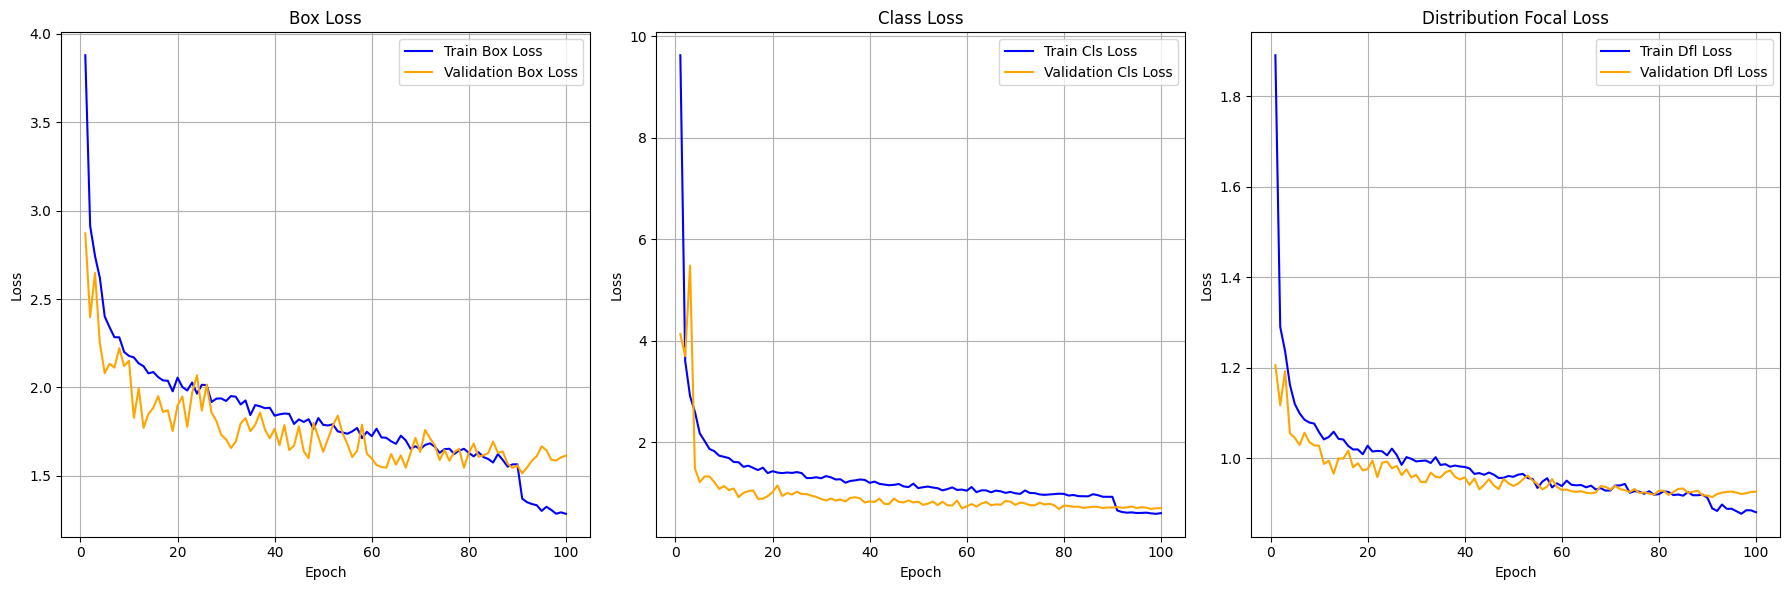

In [ ]:
epochs = results_df['epoch']
train_box_loss = results_df['train/box_loss']
val_box_loss = results_df['val/box_loss']
train_cls_loss = results_df['train/cls_loss']
val_cls_loss = results_df['val/cls_loss']
train_dfl_loss = results_df['train/dfl_loss']
val_dfl_loss = results_df['val/dfl_loss']

# create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# plot box loss
axs[0].plot(epochs, train_box_loss, label='Train Box Loss', color='blue')
axs[0].plot(epochs, val_box_loss, label='Validation Box Loss', color='orange')
axs[0].set_title('Box Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Plot CLS loss
axs[1].plot(epochs, train_cls_loss, label='Train Cls Loss', color='blue')
axs[1].plot(epochs, val_cls_loss, label='Validation Cls Loss', color='orange')
axs[1].set_title('Class Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

# plot DFL loss
axs[2].plot(epochs, train_dfl_loss, label='Train Dfl Loss', color='blue')
axs[2].plot(epochs, val_dfl_loss, label='Validation Dfl Loss', color='orange')
axs[2].set_title('Distribution Focal Loss')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Predictions on Test Dataset

In [ ]:
dest_results_dir = '/content/pcb/train3'
best_model_path = os.path.join(dest_results_dir, 
                               'weights/best.pt')
model = YOLO(best_model_path)

test_data_dir = os.path.join(output_dir, 'images/val')
metrics = model(source=test_data_dir, 
                imgsz=640, conf=0.25, 
                save=True, save_txt=True, 
                save_conf=True)


image 1/34 /kaggle/input/pcb-defects/PCB_DATASET/output/images/val/01_missing_hole_06.jpg: 640x640 3 missing_holes, 29.8ms
image 2/34 /kaggle/input/pcb-defects/PCB_DATASET/output/images/val/01_open_circuit_17.jpg: 640x640 2 open_circuits, 21.2ms
image 3/34 /kaggle/input/pcb-defects/PCB_DATASET/output/images/val/01_spurious_copper_03.jpg: 640x640 3 spurious_coppers, 25.3ms
image 4/34 /kaggle/input/pcb-defects/PCB_DATASET/output/images/val/04_mouse_bite_15.jpg: 640x640 3 mouse_bites, 21.1ms
image 5/34 /kaggle/input/pcb-defects/PCB_DATASET/output/images/val/04_mouse_bite_17.jpg: 640x640 3 mouse_bites, 29.1ms
image 6/34 /kaggle/input/pcb-defects/PCB_DATASET/output/images/val/04_open_circuit_01.jpg: 640x640 3 open_circuits, 21.7ms
image 7/34 /kaggle/input/pcb-defects/PCB_DATASET/output/images/val/04_spur_06.jpg: 640x640 3 spurs, 32.9ms
image 8/34 /kaggle/input/pcb-defects/PCB_DATASET/output/images/val/04_spur_15.jpg: 640x640 3 spurs, 35.7ms
image 9/34 /kaggle/input/pcb-defects/PCB_DATASET/

In [ ]:
predict_dir = '/content/runs/detect/predict'
#dest_predict_dir = os.path.join(root_dir,
                               # 'results/predict')

#shutil.copytree(predict_dir, dest_predict_dir)

In [ ]:
def yolo_to_original_annot(image_name, 
                           yolo_labels,
                           annot_df,
                           classes):
    original_annot = []

    for yolo_label in yolo_labels:
        # extract original width and height from annotation DataFrame
        original_size = annot_df.loc[annot_df['filename'] == image_name, ['width', 'height']].iloc[0]
        original_width, original_height = original_size['width'], original_size['height']

        # extract YOLO label components
        class_index, x_center, y_center, bbox_width, bbox_height, confidence = yolo_label

        # scale bounding box coordinates and dimensions to original size
        original_x_center = x_center * original_width
        original_y_center = y_center * original_height
        original_bbox_width = bbox_width * original_width
        original_bbox_height = bbox_height * original_height

        # calculate original bounding box coordinates
        original_x_min = original_x_center - original_bbox_width / 2
        original_y_min = original_y_center - original_bbox_height / 2
        original_x_max = original_x_center + original_bbox_width / 2
        original_y_max = original_y_center + original_bbox_height / 2

        # append original annotation to list
        original_annot.append({
            'filename': image_name,
            'width': int(original_width),
            'height': int(original_height),
            'class': classes[int(class_index)],
            'xmin': int(original_x_min),
            'ymin': int(original_y_min),
            'xmax': int(original_x_max),
            'ymax': int(original_y_max),
            'confidence': confidence
        })

    return pd.DataFrame(original_annot)

In [ ]:
def read_yolo_labels_from_file(file_path):
    labels = []
    with open(file_path, 'r') as file:
        for line in file:
            values = line.strip().split()
            values = [float(value) for value in values]
            labels.append(values)
    return labels

file_path = os.path.join(predict_dir, 'labels/01_spurious_copper_03.txt')
yolo_labels = read_yolo_labels_from_file(file_path)
yolo_labels

[[5.0, 0.617565, 0.627756, 0.0183475, 0.0591091, 0.783583],
 [5.0, 0.599819, 0.838937, 0.0173658, 0.0561687, 0.598702],
 [5.0, 0.511448, 0.57595, 0.0115632, 0.0629543, 0.538056]]

In [ ]:
pred_annot_df = yolo_to_original_annot('12_spurious_copper_10.jpg',
                                       yolo_labels, 
                                       annot_df, 
                                       classes)
pred_annot_df.head(6)

,filename,width,height,class,xmin,ymin,xmax,ymax,confidence
0,12_spurious_copper_10.jpg,2529,2530,spurious_copper,1538,1513,1585,1662,0.783583
1,12_spurious_copper_10.jpg,2529,2530,spurious_copper,1494,2051,1538,2193,0.598702
2,12_spurious_copper_10.jpg,2529,2530,spurious_copper,1278,1377,1308,1536,0.538056
